In [1]:
from nb1_module import generate_example

In [2]:
charging_unit, car_green, qcio, converter, qubo, number_binary_variables, qubo_minimization_result = generate_example(random_values=False)
print(charging_unit)
print(car_green)


Charging unit with
 charging levels: [0, 1, 2, 3]
 time slots: [0, 1, 2, 3]
 cars to charge: car_green
Car car_green: 
 at charging station at time slots [0, 1, 2] 
  requires 4 energy units


In [3]:
b_min = qubo_minimization_result.x
f_3_min = qubo_minimization_result.fval
print("minimum point (binary): b_min = ", b_min)
print("minimum value: f_3(b_min) = ", f_3_min)

minimum point (binary): b_min =  [1. 0. 0. 1. 1. 0. 0. 0.]
minimum value: f_3(b_min) =  6.0


In [4]:
p_min = converter.interpret(b_min)
f_1_min = qcio.objective.evaluate(p_min)
p_min_feasible = qcio.is_feasible(p_min)
print("minimum point (integer): p_min = ", p_min)
print("minimum value: f_1(p_min) = ", f_1_min)
print("minimum point feasible = ", p_min_feasible)

minimum point (integer): p_min =  [1. 2. 1. 0.]
minimum value: f_1(p_min) =  6.0
minimum point feasible =  True


In [5]:
from utils import plot_charging_schedule
fig = plot_charging_schedule(
charging_unit, p_min, marker_size=30)
fig.update_layout(width=350, height=300)
fig.show()

### Revisiting QUBO

The general form of QUBO has the form:

$\min\limits_{\mathbf{b} \in \{0, 1\}^n} f_3(\mathbf{b})$

$f_3( \mathbf{b}) = \mathbf{b}^T A \mathbf{b}+ L \mathbf{b} + c$

$A \in \mathbb{R}^{n \times n}; \quad L \in \mathbb{R}^{n \times 1}; \quad c \in \mathbb{R}$


(The precise form of $f_3$ is derived in nb1 where it is shown how to obtain the it from a QCIO.)
Let us transform it into an Ising Hamiltonian. Writing the equation in coordinate representation


$$f_3(\mathbf{b}) = \sum\limits_{i=0}^{n-1} \sum\limits_{j>i}^{n-1} a_{ij} b_i b_j + \sum\limits_{i=0}^{n-1} l_i b_i + c$$


The following operation is applied:

$$b_i \leftrightarrow \frac{1}{2} \left( I^{\bigotimes n} - \sigma_Z^{(i)} \right)$$

Where

$I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$,

$\sigma_Z = I\otimes ... \otimes I \otimes Z_{[\text{at ith pos}]} \otimes I \otimes...\otimes I$,

$Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$.



This substitution can be understood by using an Ising lattice that has instead of $\{-1, 1\}$ the values $\{0, 1\}$ on its sites. This is demonstrated below. 

In [8]:
import numpy as np

Z = np.array([[1, 0], [0, -1]])

print("eigenvalues of Z:", np.linalg.eig(Z)[0])
print("eigenvectors of Z:", np.linalg.eig(Z)[1][0], np.linalg.eig(Z)[1][1])
print("")

Sigma_Z =1/2 * (np.array([[1, 0], [0, 1]]) - np.array([[1, 0], [0, -1]]))
print("eigenvalues of \u03c3_z:", np.linalg.eig(Sigma_Z)[0])
print("eigenvectors of \u03c3_z:", np.linalg.eig(Sigma_Z)[1][0], np.linalg.eig(Sigma_Z)[1][1])


eigenvalues of Z: [ 1. -1.]
eigenvectors of Z: [1. 0.] [0. 1.]

eigenvalues of σ_z: [0. 1.]
eigenvectors of σ_z: [1. 0.] [0. 1.]


Thus the (problem's) Hamiltonian reads:

$$H_p = \sum\limits_{i=0}^{n-1} \sum\limits_{j>i}^{n-1} h_{ij} \sigma_Z^{(i)} \sigma_Z^{(j)} + \sum\limits_{i=0}^{n-1} h'_i \sigma_Z^{(i)} + h''I^{\otimes n} $$

A general state in the Hilbert space spanned by $\{\ket{b}\}$:

$$ {\ket{\psi}} = \sum\limits_{\mathbf{b}\in\{0,1\}^n}\lambda_b \ket{b}$$

Where for the complex $\lambda$'s:
$\sum\limits_{\mathbf{b}\in\{0,1\}^n} |\lambda_b|^2 = 1$.

The following holds: 
$\bra{\psi} H_p \ket{\psi} = \sum\limits_{{\mathbf{b}\in\{0,1\}^n}} | \lambda|^2 f_3(\mathbf{b})$

QuadraticProgram module can implements the above transformations: it creates an ising and an ising off-set function. This latter corresponds to the constant shift in energy.

In [9]:
ising, ising_offset = qubo.to_ising()

In [10]:
print("ising:", ising, "\n\n", "ising_offset:", ising_offset)

ising: SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIZII', 'IIIZZIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIZII', 'IIZIZIII', 'IIZZIIII', 'IZIIIIII', 'ZZIIIIII', 'ZIIIIIII'],
              coeffs=[-4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j,
  6.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,  6.1 +0.j,
  2.55+0.j,  5.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,
  5.1 +0.j, 10.2 +0.j,  6.1 +0.j, -1.5 +0.j,  1.  +0.j, -3.  +0.j]) 

 ising_offset: 34.39999999999999


Let's show that that the expectation value of the Hamiltonian is what we got from the equation above.
OPFLOW IS DEPRICATED, TODO LATER

In [18]:
import numpy as np
from qiskit.opflow import DictStateFn, OperatorBase
from qiskit.opflow.state_fns import OperatorStateFn

psi = DictStateFn({'00011100': .7,
                  '10101010': .2j,
                  '11110000': .6 + 1j*np.sqrt(.11)})

observable = OperatorStateFn(ising, is_measurement=True)
expectation_without_offset = np.real(observable.eval(psi))

expectation = expectation_without_offset + ising_offset

print("<\u03A8| H_p |\u03A8>", expectation)

C:\Users\uic53403\AppData\Local\Temp\ipykernel_16380\1649041562.py:5: DeprecationWarning:

The class ``qiskit.opflow.state_fns.dict_state_fn.DictStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.

C:\Users\uic53403\AppData\Local\Temp\ipykernel_16380\1649041562.py:9: DeprecationWarning:

The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.



AttributeError: 'SparsePauliOp' object has no attribute 'eval'

In [16]:
observable

OperatorStateFn(SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIZII', 'IIIZZIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIZII', 'IIZIZIII', 'IIZZIIII', 'IZIIIIII', 'ZZIIIIII', 'ZIIIIIII'],
              coeffs=[-4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j,
  6.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,  6.1 +0.j,
  2.55+0.j,  5.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,
  5.1 +0.j, 10.2 +0.j,  6.1 +0.j, -1.5 +0.j,  1.  +0.j, -3.  +0.j]), coeff=1.0, is_measurement=True)

In [13]:
ising

SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZZII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIZII', 'IIIZZIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIZII', 'IIZIZIII', 'IIZZIIII', 'IZIIIIII', 'ZZIIIIII', 'ZIIIIIII'],
              coeffs=[-4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j, -4.05+0.j, -8.1 +0.j,
  6.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,  6.1 +0.j,
  2.55+0.j,  5.1 +0.j,  2.55+0.j,  5.1 +0.j,  5.1 +0.j, 10.2 +0.j,
  5.1 +0.j, 10.2 +0.j,  6.1 +0.j, -1.5 +0.j,  1.  +0.j, -3.  +0.j])

In [19]:
from qiskit.circuit.library import QAOAAnsatz

qaoa_reps = 2
qaoa_ansatz = QAOAAnsatz(cost_operator=ising, reps=qaoa_reps, name = "qaoa")
qaoa_ansatz.measure_active()

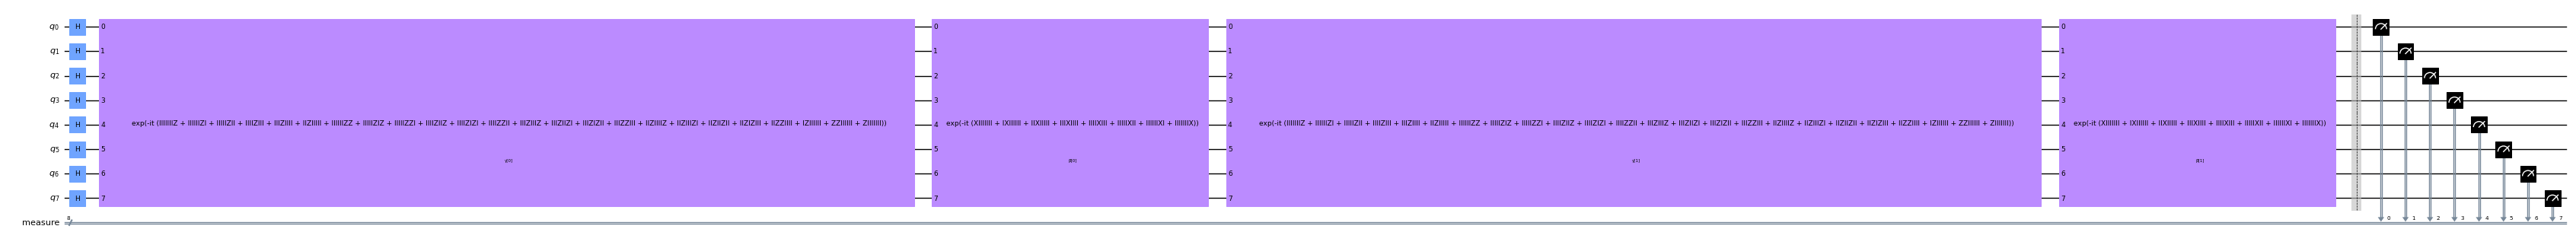

In [21]:
qaoa_ansatz.decompose(reps=1).draw("mpl",scale = .5, fold =-1)